In [1]:
%cd ../../

/home/novelli/encoderops


In [2]:
from dotenv import load_dotenv
import xarray as xr
from pathlib import Path
import os
import torch
from src.data import SSTDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pathlib import Path
from src.model import EvolutionOperator
from src.data import SSTDataModule
from src.configs import TrainerArgs, SSTDataArgs # noqa
import numpy as np

load_dotenv()

True

In [92]:
run_id = "pkalgzid"
ckpt_path = f"/home/novelli/encoderops/logs/encoderops-ENSO/{run_id}/checkpoints/last.ckpt"

In [93]:
model = EvolutionOperator.load_from_checkpoint(ckpt_path)
data_args = torch.load(ckpt_path, weights_only=False)['SSTDataModule']['data_args']
data_args = SSTDataArgs(**data_args)
datamodule = SSTDataModule(model.trainer_args, data_args = data_args, num_workers = 1)
stage = "fit"
datamodule.setup(stage)
ds = datamodule.train_dataset if stage == "fit" else datamodule.full_dataset

2025-05-21 20:59:55.907 | INFO     | src.data:__init__:588 - Dataset loaded with 449 samples.
2025-05-21 20:59:57.323 | INFO     | src.data:__init__:588 - Dataset loaded with 77 samples.


In [95]:
emb_X = []
emb_Y = []
emb_YP = []
X = []
Y = []
times = []
model.eval()
with torch.no_grad():
    for sample in ds:
        x = sample['x'].to(model.device).unsqueeze(0)
        y = sample['y'].to(model.device).unsqueeze(0)
        times.append(np.datetime64(sample['time'][0]))        
        emb_X.append(model.forward_nn(x))
        X.append(x[0,0])
        emb_Y.append(model.forward_nn(y))
        emb_YP.append(model.forward_nn(y, lagged=True))
        Y.append(y[0,0])
emb_X = torch.cat(emb_X)
emb_Y = torch.cat(emb_Y)
emb_YP = torch.cat(emb_YP)
X = torch.stack(X)
Y = torch.stack(Y)

embeddings = {
    "X": X.cpu(),
    "Y": Y.cpu(),
    "emb_X": emb_X.cpu(),
    "emb_Y": emb_Y.cpu(),
    "emb_YP": emb_YP.cpu(),
    "times": times
}


In [96]:
time_mask = ds.oni.time.isin(embeddings['times'])
oni = ds.oni.sel(time=time_mask)

In [97]:
K = embeddings['emb_X']@embeddings['emb_YP'].T

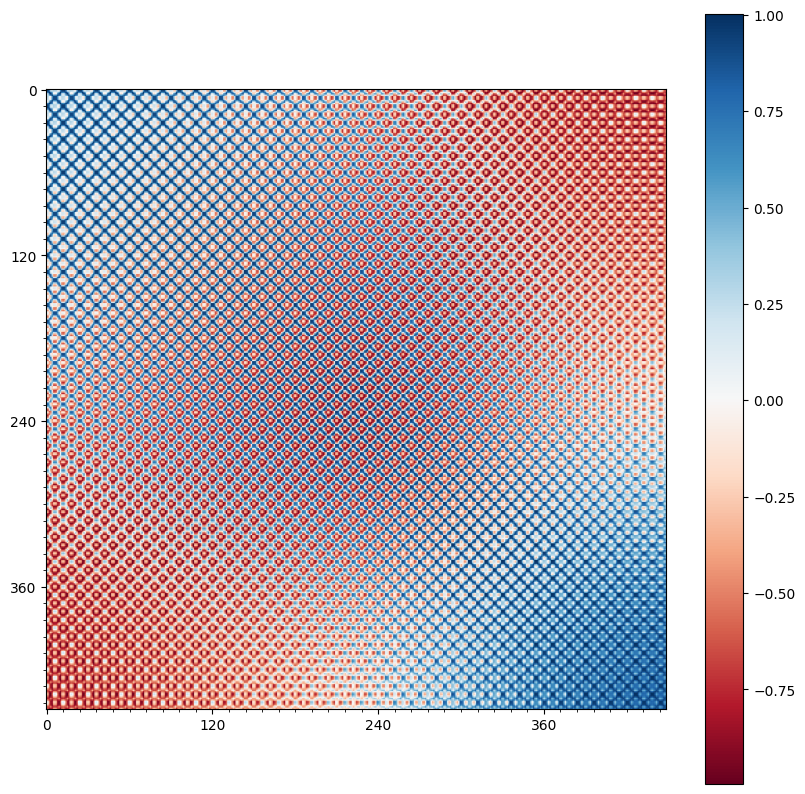

In [99]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))



im = ax.imshow(K, cmap="RdBu")
major_ticks = np.arange(0, K.shape[0], 120)
minor_ticks = np.arange(0, K.shape[0], 12)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
#ax.grid(which='both', alpha=0.5, color='k')

fig.colorbar(im)

In [83]:
from loguru import logger
from math import sqrt

@torch.no_grad()
def modes(obs_Y: torch.Tensor, emb_Y: torch.Tensor, model:EvolutionOperator, reg: float=1e-4):
    G = model.get_transfer_operator(reg=reg).cpu()
    cov_Y = model.covariances.cov_Y.cpu()
    cov_Y += torch.eye(G.shape[0], dtype=cov_Y.dtype, device=cov_Y.device)*reg
    logger.info("Computed estimator")
    l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
    logger.info("Computed eig decomposition")
    obs_shape = obs_Y.shape[1:]
    logger.info(f"Flattening observable shape {obs_shape}")
    norm = sqrt(emb_Y.shape[0])
    coeffs = torch.tensordot(emb_Y.T/norm, obs_Y.view(obs_Y.shape[0], -1)/norm, dims=1)
    logger.info(f"coeffs shape: {coeffs.shape} | min: {coeffs.min():.2f} | max {coeffs.max():.2f} ")
    Z = torch.linalg.solve(cov_Y.cfloat()@Q, coeffs.cfloat())
    logger.info(f"Computed modes, of shape {Z.shape}")
    Z = Z.view(-1, *obs_shape)
    logger.info(f"Reshaped modes to {Z.shape}")
    return l, Q, cov_Y, Z

In [84]:
observable = embeddings["Y"]
emb_Y = embeddings["emb_Y"]
emb_X = embeddings["emb_X"]
l, Q, cov_Y, coeffs = modes(observable, emb_Y, model)
right_efns = emb_X.to(Q.dtype)@Q
left_efns = torch.linalg.solve(cov_Y.to(Q.dtype)@Q, emb_X.to(Q.dtype).T).T

2025-05-21 20:19:06.257 | INFO     | __main__:modes:9 - Computed estimator
2025-05-21 20:19:06.259 | INFO     | __main__:modes:11 - Computed eig decomposition
2025-05-21 20:19:06.259 | INFO     | __main__:modes:13 - Flattening observable shape torch.Size([121, 240])
2025-05-21 20:19:06.308 | INFO     | __main__:modes:16 - coeffs shape: torch.Size([16, 29040]) | min: -0.31 | max 0.33 
2025-05-21 20:19:06.316 | INFO     | __main__:modes:18 - Computed modes, of shape torch.Size([16, 29040])
2025-05-21 20:19:06.317 | INFO     | __main__:modes:20 - Reshaped modes to torch.Size([16, 121, 240])



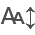

/tmp/ipykernel_1342417/272504554.py:15: RuntimeWarning: divide by zero encountered in reciprocal
  inv_angles = np.where(np.abs(angles) <= 1e-12, 0, angles**-1)


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


In [85]:
import pandas as pd
from itables import init_notebook_mode
import numpy as np

init_notebook_mode(all_interactive=True)
koopman_values = l.numpy(force=True)

def get_decorrelation(ev, days_lag):
    decorrelation = (1/-np.log(np.abs(ev)))*days_lag / 365.25
    return decorrelation


def get_frequency(ev, days_lag):
    angles = np.angle(ev)
    inv_angles = np.where(np.abs(angles) <= 1e-12, 0, angles**-1)
    frequency = 2 * np.pi * inv_angles*days_lag / 365.25
    return frequency

def plot_eigfun(mode_idx, other_mode_idx, l, times, oni, right_efns, left_efns):
    fig, axs = plt.subplots(nrows=3, figsize=(12, 8))
    ax = axs[0]
    ax.grid(alpha=0.4)
    x = np.linspace(0, 2*np.pi)
    ax.plot(np.sin(x), np.cos(x), color='gray')
    ax.scatter(l.real, l.imag, marker='x', color='k')
    ax.scatter(l[mode_idx].real, l[mode_idx].imag, color='r', marker='x')
    if other_mode_idx is not None:
        ax.scatter(l[other_mode_idx].real, l[other_mode_idx].imag, color='b', marker='x')
    ax.axis('equal')

    ax = axs[1]
    ax.plot(times, right_efns[:, mode_idx].imag, '-.', color='r', alpha=0.5)
    ax.plot(times, right_efns[:, mode_idx].real, color='r')

    ax.plot(times, left_efns[:, mode_idx].imag, '-.', color='g', alpha=0.5)
    ax.plot(times, left_efns[:, mode_idx].real, color='g')
    ax.axvline(x=np.datetime64('2017-01-01'), color='grey', linestyle='--')
    if other_mode_idx is not None:
        ax.plot(times, right_efns[:, other_mode_idx].imag, '-.', color='b', alpha=0.5)
        ax.plot(times, right_efns[:, other_mode_idx].real, color='b')
    ax.set_xmargin(0)

    ax = axs[2]
    oni = oni.__xarray_dataarray_variable__.values
    ax.plot(times, oni, color='k')
    eigfn = right_efns[:, mode_idx].real

    ax.plot(times, 6*eigfn/np.ptp(eigfn), color='g')
    ax.axhline(y=0, color='k', lw=0.5)
    ax.axvline(x=np.datetime64('2017-01-01'), color='grey', linestyle='--')

    ax.set_xmargin(0)
    return fig, ax

dict_df = {
    "index": np.arange(len(koopman_values)),
    "real": koopman_values.real,
    "imag": koopman_values.imag,
    "abs": np.abs(koopman_values),
    "decorrelation (yr)": get_decorrelation(koopman_values, 30.5),
    "frequency (yr)": get_frequency(koopman_values, 30.5),
}

results = pd.DataFrame.from_dict(dict_df)
filtered_results = results[results['decorrelation (yr)'] > 0.]
filtered_results

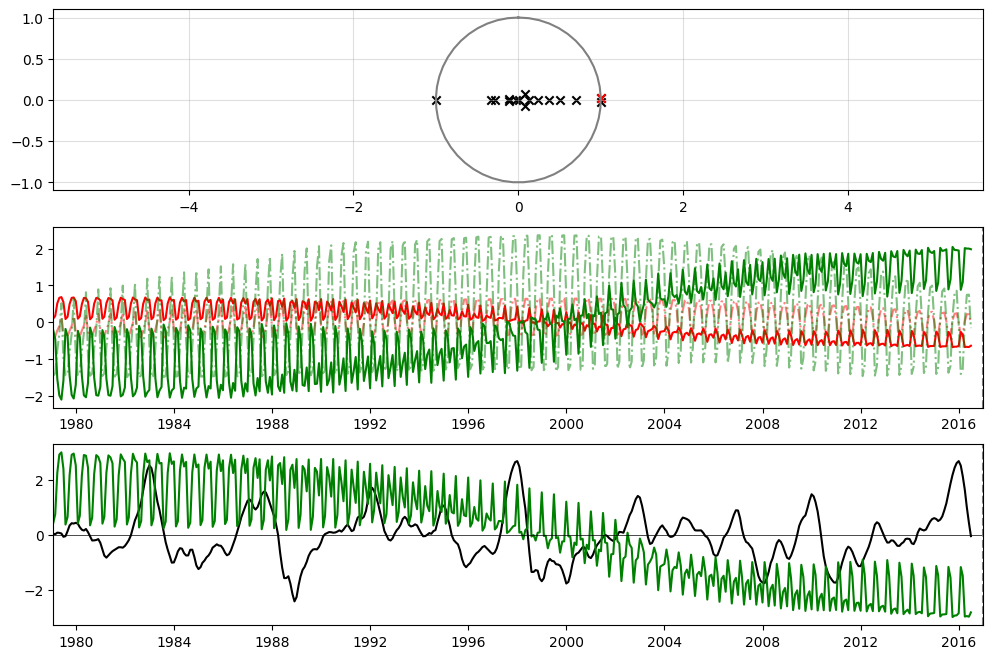

In [91]:
mode_idx = 1
other_mode_idx = None
fig, ax = plot_eigfun(mode_idx, other_mode_idx, l, times, oni, -right_efns, left_efns)

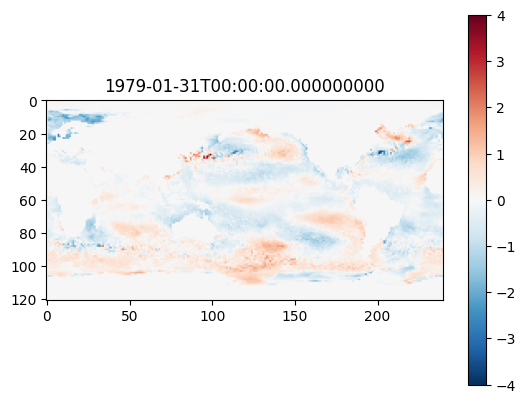

In [21]:
idx = 0
_data = dataset[idx]
plt.imshow(_data['x'][0], cmap="RdBu_r", vmin=-4, vmax=4)
plt.title(_data['time'][0])
plt.colorbar()

In [22]:
t = dataset.oni.time
oni = dataset.oni.__xarray_dataarray_variable__.values
oni_full = dataset.oni_full.__xarray_dataarray_variable__.values

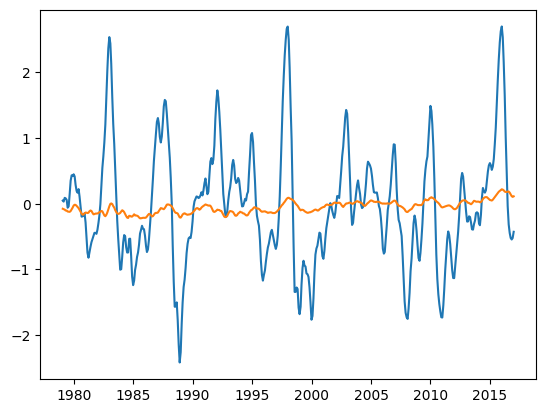

In [23]:
plt.plot(t, oni)
plt.plot(t, oni_full)

In [14]:
data = dataset.data
mean = data.mean(axis = 0)
std = data.std(axis=0)

data_std = (data - mean)/std

/tmp/ipykernel_1268673/2691434972.py:5: RuntimeWarning: invalid value encountered in divide
  data_std = (data - mean)/std


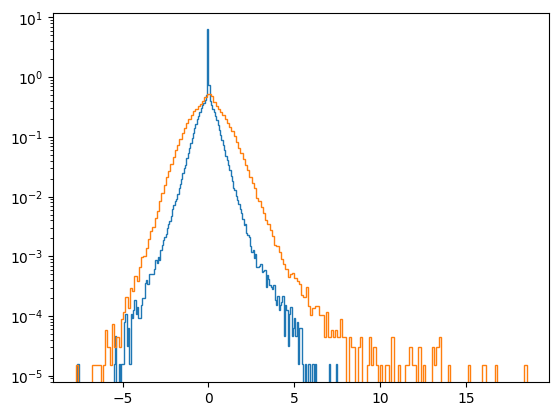

In [15]:
plt.hist(data[:, ::4, ::4].flatten(), bins=200, log=True, density=True, histtype='step');
plt.hist(data_std[:, ::4, ::4].flatten(), bins=200, log=True, density=True, histtype='step');

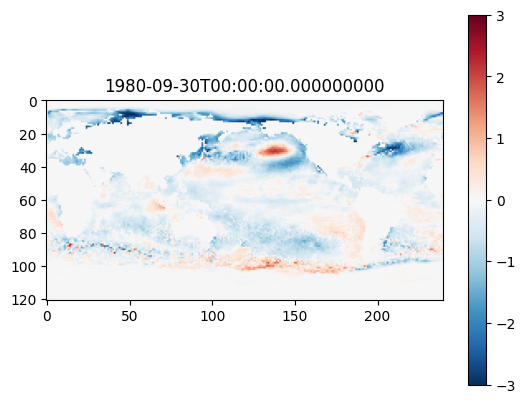

In [27]:
idx = 20
plt.imshow(data[idx], cmap="RdBu_r", vmin=-3, vmax = 3)
plt.title(dataset.time[idx])
plt.colorbar()

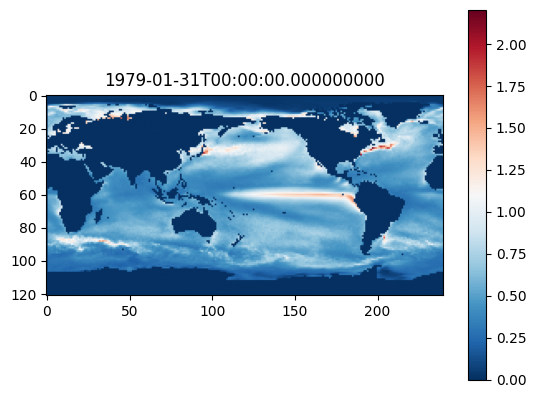

In [24]:
plt.imshow(std, cmap="RdBu_r")
plt.title(dataset.time[idx])
plt.colorbar()